In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, GaussianNoise, UpSampling2D, Conv2DTranspose, Conv2D, Dense, Lambda, Input, Flatten, Reshape, BatchNormalization, ReLU, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse, binary_crossentropy, BinaryCrossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import RandomNormal
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [143]:
def build_discriminator(img_size):
    input_layer = Input(shape=img_size)
    
    x = GaussianNoise(stddev=1)(input_layer)
    init = RandomNormal(stddev=0.02)
    
    # Feature extractor
    x = Conv2D(16,5,2, padding='same', kernel_initializer=init)(x)
#     x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.1)(x)

    
    x = Conv2D(32,5,2, padding='same', kernel_initializer=init)(x)
#     x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.1)(x)

    
    
    x = Conv2D(64,3,2, padding='same', kernel_initializer=init)(x)
#     x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.1)(x)


    
    x = Conv2D(128,5,2, padding='same', kernel_initializer=init)(x)
#     x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.1)(x)
    x = Dropout(0.5)(x)
  
    


    # Classifier

    
    x = Flatten()(x)
    
#     x = Dense(128)(x)
#     x = Dropout(0.4)(x)
    
#     x = Dense(64)(x)
#     x = Dropout(0.4)(x)
    
#     x = LeakyReLU(0.1)(x)
    x = Dense(100)(x)
    x = Dropout(0.3)(x)
    
    x = LeakyReLU(0.1)(x)
    x = Dense(1, activation='sigmoid')(x) 
    return Model(input_layer, x)
build_discriminator((64,64,3)).summary()

Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
gaussian_noise_23 (GaussianN (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 32, 32, 16)        1216      
_________________________________________________________________
leaky_re_lu_157 (LeakyReLU)  (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 16, 16, 32)        12832     
_________________________________________________________________
leaky_re_lu_158 (LeakyReLU)  (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 8, 8, 64)          184

In [144]:
def build_generator(latent_size):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    input_layer = Input(shape=(latent_size,))
    
    x = Dense(8*8*64, kernel_initializer=init)(input_layer)

    x = LeakyReLU(0.1)(x)
    
    x = Reshape((8,8,64))(x)
    

    
    x = UpSampling2D(2)(x)
    x = Conv2D(64,5,1,padding="same", kernel_initializer=init)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.1)(x)
    
    x = UpSampling2D(2)(x)
    x = Conv2D(32,5,1,padding="same", kernel_initializer=init)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0.1)(x)
    
    
    x = UpSampling2D(2)(x)
    x = Conv2D(3,7,1,padding="same", activation="tanh")(x)
    
    
    
    return Model(input_layer, x)
build_generator(100).summary()

Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense_59 (Dense)             (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_162 (LeakyReLU)  (None, 4096)              0         
_________________________________________________________________
reshape_14 (Reshape)         (None, 8, 8, 64)          0         
_________________________________________________________________
up_sampling2d_42 (UpSampling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 16, 16, 64)        102464    
_________________________________________________________________
batch_normalization_76 (Batc (None, 16, 16, 64)        256

In [11]:
def train_discriminator(train_data, batch_size, num_batches):
    real = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))
    loss_real_total = 0
    acc_real_total = 0
    loss_fake_total = 0
    acc_fake_total = 0
    
    d_loss_total = 0
    d_acc_total = 0
    for index in range(num_batches):

        # train fake images
        noise = np.random.normal(0,1, (batch_size, 100))
        fake_imgs = generator.predict(noise)
        real_imgs = train_data[index*batch_size: batch_size*(index+1)]
        
#         training_imgs = np.concatenate((real_imgs,fake_imgs))
#         training_labels = np.concatenate((real,fake))
        
#         np.random.seed(index)
#         np.random.shuffle(training_imgs)
#         np.random.seed(index)
#         np.random.shuffle(training_labels)
        
        
#         d_loss, d_acc = discriminator.train_on_batch(training_imgs, training_labels)   
#         d_loss_total += d_loss
#         d_acc_total += d_acc
        
        loss_fake, acc_fake = discriminator.train_on_batch(fake_imgs, fake)   
        loss_fake_total += loss_fake
        acc_fake_total += acc_fake
        
        # train real images
        
        loss_real, acc_real = discriminator.train_on_batch(real_imgs, real)
        loss_real_total += loss_real
        acc_real_total += acc_real

       
    loss_real_mean = loss_real_total / num_batches
    acc_real_mean = acc_real_total / num_batches
    loss_fake_mean = loss_fake_total / num_batches
    acc_fake_mean = acc_fake_total / num_batches
    return ((loss_real_mean, acc_real_mean), (loss_fake_mean, acc_fake_mean))

In [12]:
def train_generator(batch_size, num_batches):
    real = np.ones((batch_size*2,1))
    loss_gan_total = 0
    acc_gan_total = 0
    for _ in range(num_batches):
        noise = np.random.normal(0,1, (batch_size*2, 100))
        loss_gan, acc_gan = gan.train_on_batch(noise, real)
        loss_gan_total += loss_gan
        acc_gan_total += acc_gan
    return (loss_gan_total/(num_batches), acc_gan_total/(num_batches))

In [66]:
import cv2
import glob
def data_loader(file_path):
    img_paths = glob.glob(file_path + '/*')
    data = []
    for img_path in img_paths:
        
        data.append(normalize_for_tanh(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)))
    return np.array(data)

def normalize_for_tanh(img):
    return (img - 127.5) / 127.5

def unnormalize_tanh(img):
    return (img + 1) / 2

X = data_loader('./sprites/')

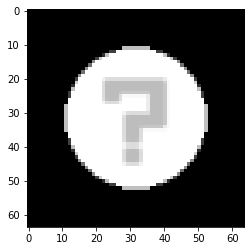

In [69]:
plt.imshow(unnormalize_tanh(X[0]))

In [157]:
generator_optimizer = Adam(0.0001)
discriminator_optimizer = Adam(0.0001)
cross_entropy = BinaryCrossentropy()
generator = build_generator(100)
discriminator = build_discriminator((64,64,3))
history = {'d_loss':[], 'g_loss':[]}

In [158]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def discriminator_loss_flipped(real_output, fake_output):
    real_loss = cross_entropy(tf.zeros_like(real_output), real_output)
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [159]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [160]:
@tf.function
def train_step(images):
    noise = tf.random.normal([32,100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return disc_loss, gen_loss

In [161]:
@tf.function
def train_step_flipped(images):
    noise = tf.random.normal([32,100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss_flipped(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return disc_loss, gen_loss

In [162]:
epochs = 1000
batch_size = 32



noise = np.random.normal(0,1, 100)
num_batches = int(len(X) // batch_size)


for epoch in range(epochs):
    print(f'Epoch [{epoch}/{epochs-1}]...'.ljust(20), end = '')
    np.random.seed(epoch)
    np.random.shuffle(X)
    disc_loss_total = 0
    gen_loss_total = 0
    
    for index in range(num_batches):
        
#         if index % 5 == 2:
#             _, _ = train_step_flipped(X[index*batch_size: batch_size*(index+1)])            
        disc_loss, gen_loss = train_step(X[index*batch_size: batch_size*(index+1)])
        disc_loss_total += disc_loss
        gen_loss_total += gen_loss
        
    disc_loss = disc_loss_total / num_batches
    gen_loss = gen_loss_total / num_batches
    history['d_loss'].append(disc_loss)
    history['g_loss'].append(gen_loss)
    print(f'd_loss:{disc_loss:.5f} g_loss:{gen_loss:.5f}')


#     if epoch % 100 == 9 or epoch == 1:
#         plt.imshow(unnormalize_tanh(generator.predict(np.array([noise]))[0]))
#         plt.title(f'Epoch {epoch}')
#         plt.show()
        

Epoch [0/999]...    WARNING:tensorflow:Layer gaussian_noise_26 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

d_loss:1.36764 g_loss:0.66731
Epoch [1/999]...    d_loss:1.31799 g_loss:0.67085
Epoch [2/999]...    d_loss:1.32698 g_loss:0.71718
Epoch [3/999]...    d_loss:1.21314 g_loss:0.88347
Epoch [4/999]...    d_loss:1.61265 g_loss:0.68989
Epoch [5/999]...    d_loss:1.

Epoch [150/999]...  d_loss:1.36306 g_loss:0.80577
Epoch [151/999]...  d_loss:1.27463 g_loss:0.81172
Epoch [152/999]...  d_loss:1.40111 g_loss:0.70242
Epoch [153/999]...  d_loss:1.38691 g_loss:0.67304
Epoch [154/999]...  d_loss:1.33621 g_loss:0.68524
Epoch [155/999]...  d_loss:1.22203 g_loss:0.82753
Epoch [156/999]...  d_loss:1.35771 g_loss:0.74018
Epoch [157/999]...  d_loss:1.28331 g_loss:0.70874
Epoch [158/999]...  d_loss:1.20294 g_loss:0.76937
Epoch [159/999]...  d_loss:1.20053 g_loss:0.83352
Epoch [160/999]...  d_loss:1.33967 g_loss:0.72780
Epoch [161/999]...  d_loss:1.33753 g_loss:0.80677
Epoch [162/999]...  d_loss:1.35019 g_loss:0.81561
Epoch [163/999]...  d_loss:1.29198 g_loss:0.81835
Epoch [164/999]...  d_loss:1.40276 g_loss:0.71842
Epoch [165/999]...  d_loss:1.39397 g_loss:0.69835
Epoch [166/999]...  d_loss:1.31666 g_loss:0.68440
Epoch [167/999]...  d_loss:1.30225 g_loss:0.77469
Epoch [168/999]...  d_loss:1.38823 g_loss:0.80176
Epoch [169/999]...  d_loss:1.41796 g_loss:0.77972


Epoch [314/999]...  d_loss:1.34070 g_loss:1.28974
Epoch [315/999]...  d_loss:1.51105 g_loss:0.73953
Epoch [316/999]...  d_loss:1.40046 g_loss:0.73475
Epoch [317/999]...  d_loss:1.29163 g_loss:0.73269
Epoch [318/999]...  d_loss:1.03406 g_loss:0.97068
Epoch [319/999]...  d_loss:1.16671 g_loss:1.04381
Epoch [320/999]...  d_loss:1.11391 g_loss:1.18565
Epoch [321/999]...  d_loss:1.15782 g_loss:0.89053
Epoch [322/999]...  d_loss:1.10203 g_loss:1.01463
Epoch [323/999]...  d_loss:1.13722 g_loss:1.00598
Epoch [324/999]...  d_loss:1.09804 g_loss:0.98987
Epoch [325/999]...  d_loss:1.06778 g_loss:1.02525
Epoch [326/999]...  d_loss:1.10896 g_loss:1.02250
Epoch [327/999]...  d_loss:1.14122 g_loss:0.96811
Epoch [328/999]...  d_loss:1.19100 g_loss:0.94093
Epoch [329/999]...  d_loss:1.27644 g_loss:0.92865
Epoch [330/999]...  d_loss:1.20584 g_loss:0.86616
Epoch [331/999]...  d_loss:1.14817 g_loss:0.91896
Epoch [332/999]...  d_loss:1.15003 g_loss:1.02072
Epoch [333/999]...  d_loss:1.20496 g_loss:0.97171


Epoch [478/999]...  d_loss:1.07252 g_loss:0.91786
Epoch [479/999]...  d_loss:1.26019 g_loss:1.03411
Epoch [480/999]...  d_loss:1.14052 g_loss:0.97467
Epoch [481/999]...  d_loss:0.98952 g_loss:1.14940
Epoch [482/999]...  d_loss:1.01250 g_loss:1.03081
Epoch [483/999]...  d_loss:0.93210 g_loss:1.22001
Epoch [484/999]...  d_loss:1.17648 g_loss:1.13080
Epoch [485/999]...  d_loss:0.99162 g_loss:1.08083
Epoch [486/999]...  d_loss:0.81342 g_loss:1.16866
Epoch [487/999]...  d_loss:0.89671 g_loss:1.23560
Epoch [488/999]...  d_loss:1.29333 g_loss:1.09727
Epoch [489/999]...  d_loss:0.94110 g_loss:1.08343
Epoch [490/999]...  d_loss:0.78122 g_loss:1.26358
Epoch [491/999]...  d_loss:1.24095 g_loss:1.20161
Epoch [492/999]...  d_loss:1.03624 g_loss:1.07367
Epoch [493/999]...  d_loss:0.80740 g_loss:1.21230
Epoch [494/999]...  d_loss:1.05802 g_loss:1.20586
Epoch [495/999]...  d_loss:1.04003 g_loss:1.12686
Epoch [496/999]...  d_loss:0.75143 g_loss:1.34745
Epoch [497/999]...  d_loss:0.91273 g_loss:1.44567


Epoch [642/999]...  d_loss:1.01250 g_loss:1.30630
Epoch [643/999]...  d_loss:0.96875 g_loss:1.30411
Epoch [644/999]...  d_loss:0.94514 g_loss:1.22905
Epoch [645/999]...  d_loss:0.96024 g_loss:1.28513
Epoch [646/999]...  d_loss:0.97395 g_loss:1.31045
Epoch [647/999]...  d_loss:0.98270 g_loss:1.27758
Epoch [648/999]...  d_loss:0.96377 g_loss:1.28579
Epoch [649/999]...  d_loss:1.05240 g_loss:1.15538
Epoch [650/999]...  d_loss:0.87449 g_loss:1.36336
Epoch [651/999]...  d_loss:1.20144 g_loss:1.27693
Epoch [652/999]...  d_loss:0.90217 g_loss:1.37505
Epoch [653/999]...  d_loss:0.99708 g_loss:1.35995
Epoch [654/999]...  d_loss:0.98354 g_loss:1.12675
Epoch [655/999]...  d_loss:0.87783 g_loss:1.41617
Epoch [656/999]...  d_loss:1.23180 g_loss:1.29548
Epoch [657/999]...  d_loss:1.04025 g_loss:1.31110
Epoch [658/999]...  d_loss:1.00369 g_loss:1.21997
Epoch [659/999]...  d_loss:0.86591 g_loss:1.24797
Epoch [660/999]...  d_loss:1.06398 g_loss:1.24009
Epoch [661/999]...  d_loss:1.11453 g_loss:1.07149


Epoch [806/999]...  d_loss:1.01195 g_loss:1.35904
Epoch [807/999]...  d_loss:0.89351 g_loss:1.42831
Epoch [808/999]...  d_loss:0.77236 g_loss:1.50832
Epoch [809/999]...  d_loss:0.89507 g_loss:1.42925
Epoch [810/999]...  d_loss:1.03275 g_loss:1.40532
Epoch [811/999]...  d_loss:0.92002 g_loss:1.40686
Epoch [812/999]...  d_loss:0.79381 g_loss:1.63691
Epoch [813/999]...  d_loss:0.92677 g_loss:1.52053
Epoch [814/999]...  d_loss:0.94476 g_loss:1.38058
Epoch [815/999]...  d_loss:0.86016 g_loss:1.40875
Epoch [816/999]...  d_loss:0.82508 g_loss:1.42783
Epoch [817/999]...  d_loss:0.85547 g_loss:1.51666
Epoch [818/999]...  d_loss:0.86814 g_loss:1.48350
Epoch [819/999]...  d_loss:0.89524 g_loss:1.50041
Epoch [820/999]...  d_loss:0.87880 g_loss:1.58938
Epoch [821/999]...  d_loss:0.86931 g_loss:1.53733
Epoch [822/999]...  d_loss:0.78623 g_loss:1.54592
Epoch [823/999]...  d_loss:0.88691 g_loss:1.49996
Epoch [824/999]...  d_loss:0.77187 g_loss:1.55086
Epoch [825/999]...  d_loss:0.87157 g_loss:1.66570


Epoch [970/999]...  d_loss:0.70486 g_loss:2.09839
Epoch [971/999]...  d_loss:0.62320 g_loss:2.04744
Epoch [972/999]...  d_loss:0.62606 g_loss:2.07648
Epoch [973/999]...  d_loss:0.73928 g_loss:1.94027
Epoch [974/999]...  d_loss:0.62460 g_loss:2.02726
Epoch [975/999]...  d_loss:0.65691 g_loss:2.14781
Epoch [976/999]...  d_loss:0.73869 g_loss:2.10841
Epoch [977/999]...  d_loss:0.64981 g_loss:1.96684
Epoch [978/999]...  d_loss:0.62334 g_loss:2.18553
Epoch [979/999]...  d_loss:0.71634 g_loss:1.96561
Epoch [980/999]...  d_loss:0.70815 g_loss:2.02759
Epoch [981/999]...  d_loss:0.65245 g_loss:1.97004
Epoch [982/999]...  d_loss:0.63671 g_loss:2.16922
Epoch [983/999]...  d_loss:0.67766 g_loss:2.04781
Epoch [984/999]...  d_loss:0.65479 g_loss:2.03787
Epoch [985/999]...  d_loss:0.60853 g_loss:2.07764
Epoch [986/999]...  d_loss:0.70172 g_loss:1.98427
Epoch [987/999]...  d_loss:0.65090 g_loss:2.06388
Epoch [988/999]...  d_loss:0.64159 g_loss:2.11702
Epoch [989/999]...  d_loss:0.67294 g_loss:2.05722


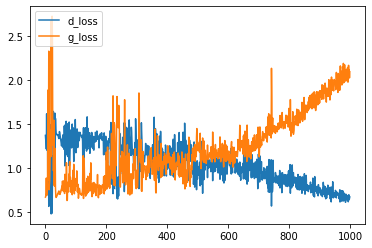

In [163]:
for key in history:
    plt.plot(history[key], label=key)
    plt.legend(loc="upper left")
plt.show()

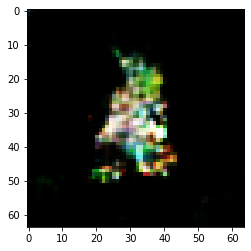

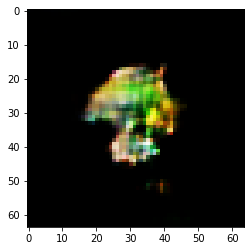

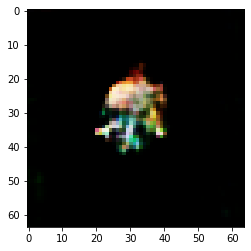

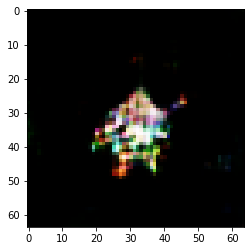

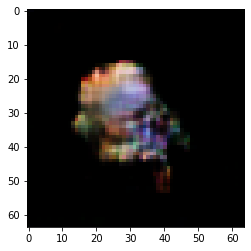

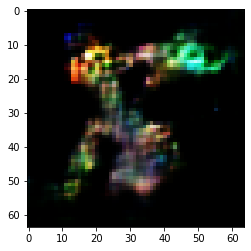

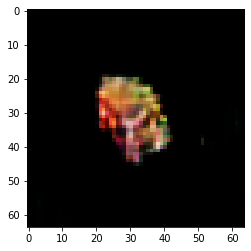

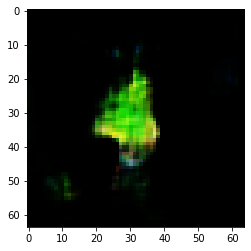

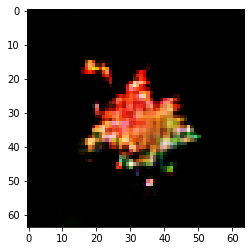

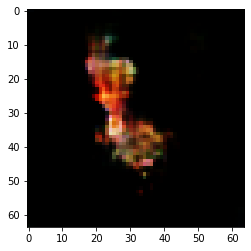

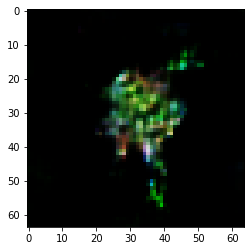

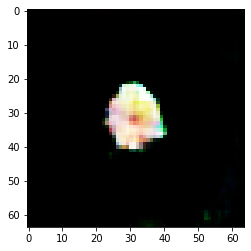

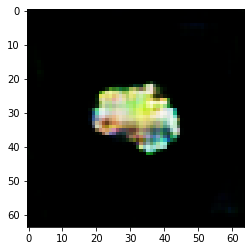

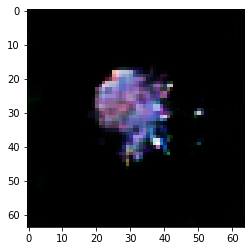

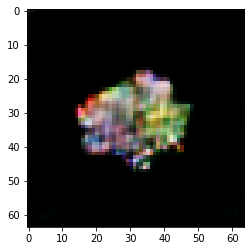

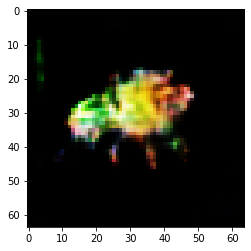

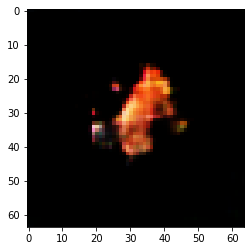

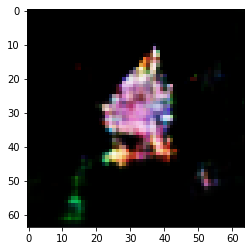

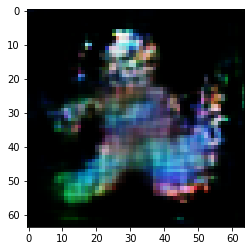

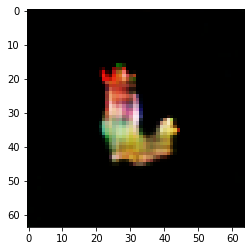

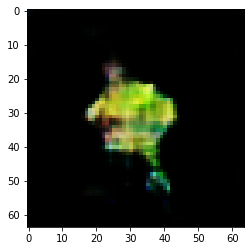

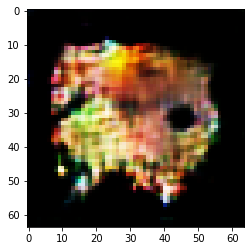

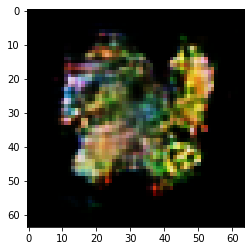

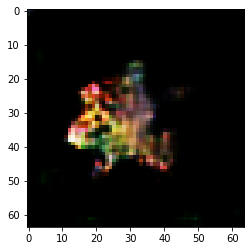

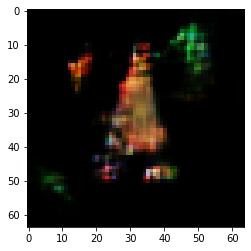

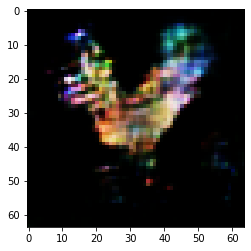

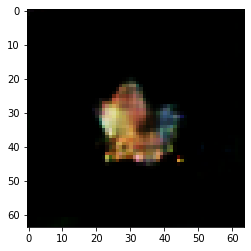

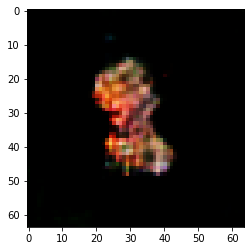

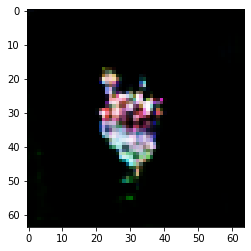

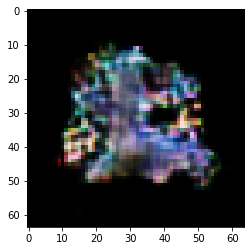

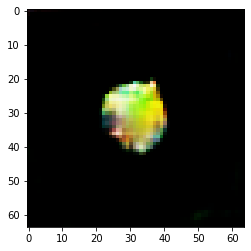

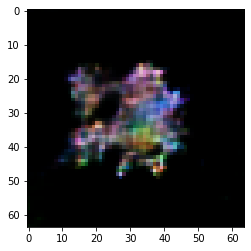

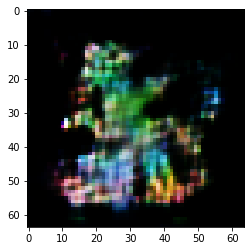

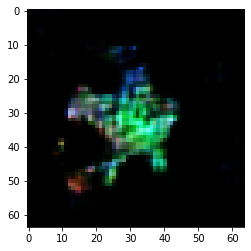

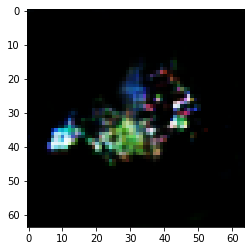

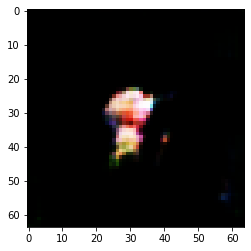

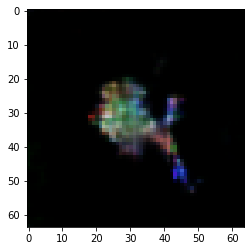

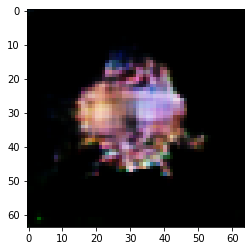

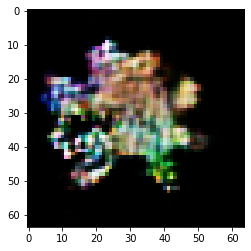

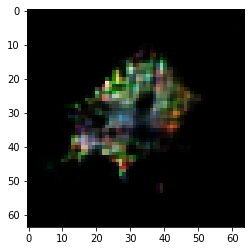

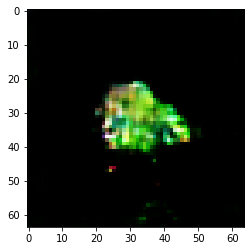

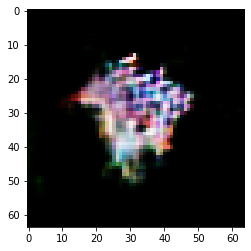

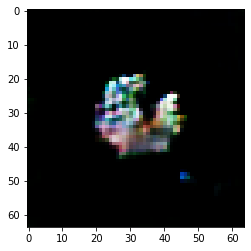

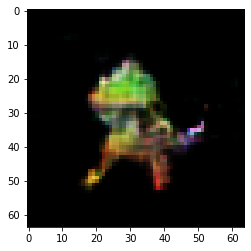

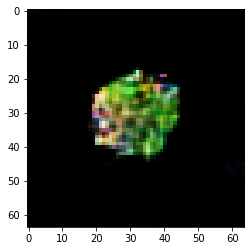

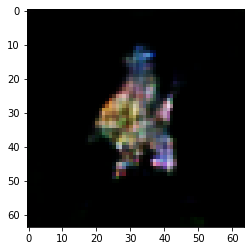

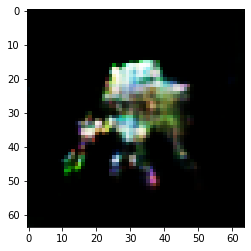

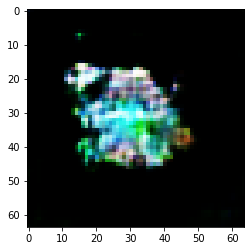

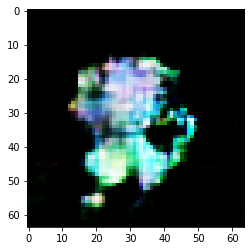

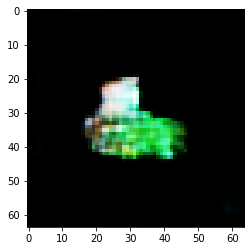

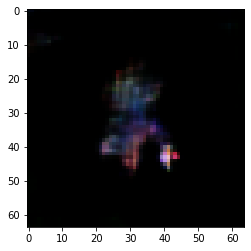

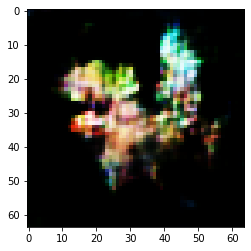

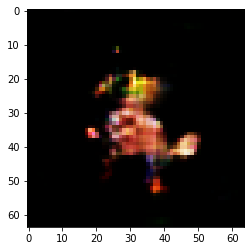

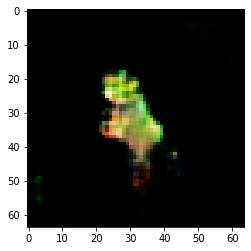

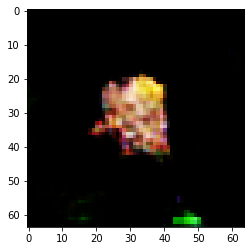

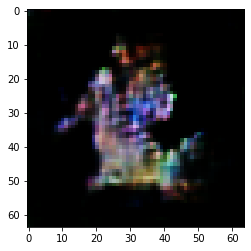

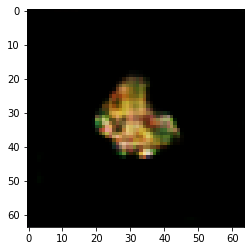

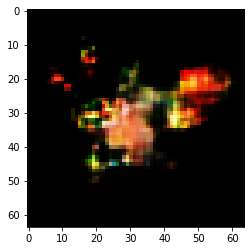

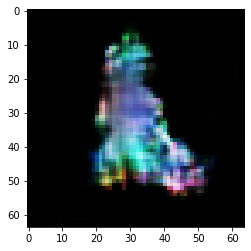

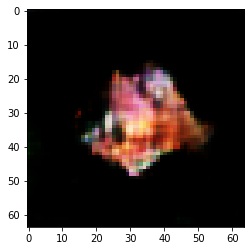

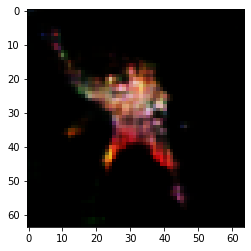

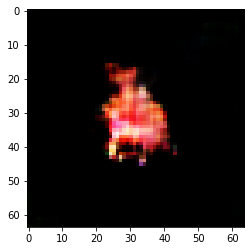

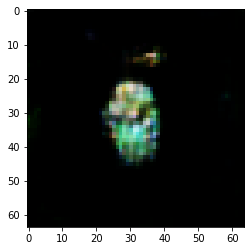

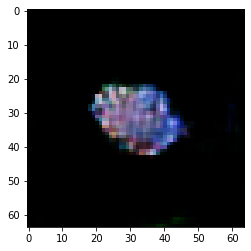

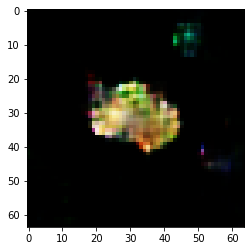

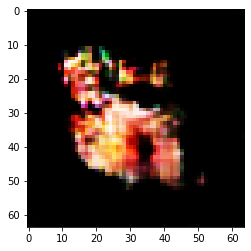

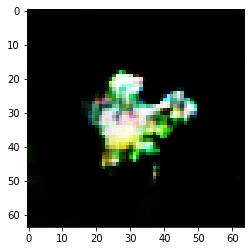

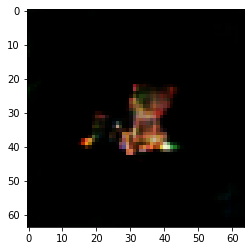

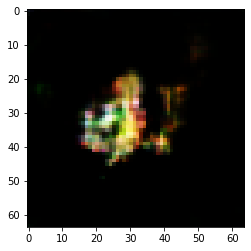

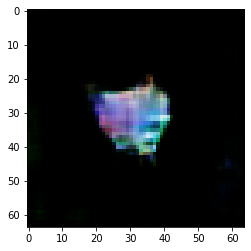

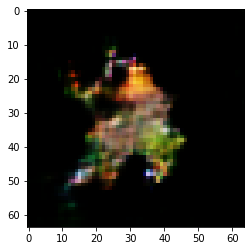

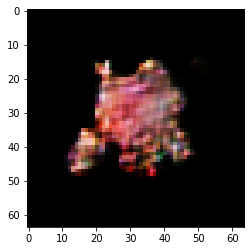

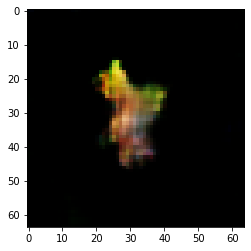

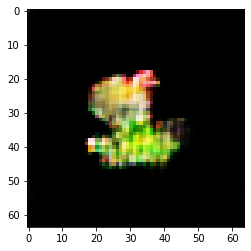

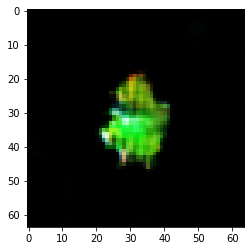

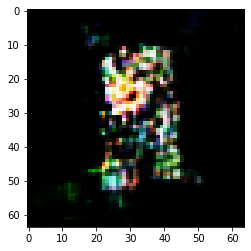

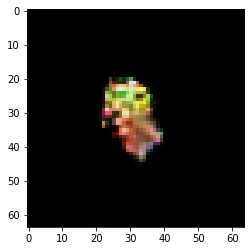

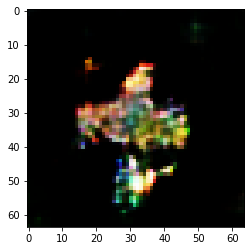

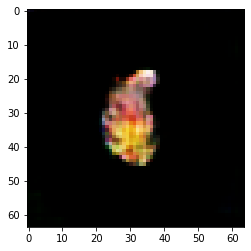

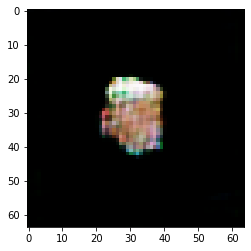

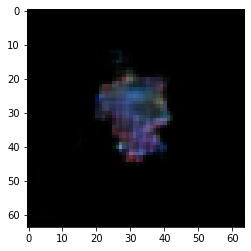

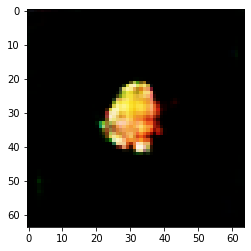

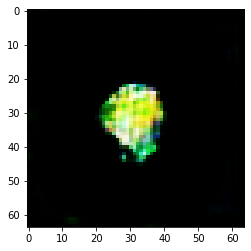

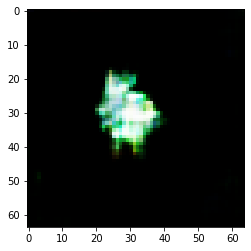

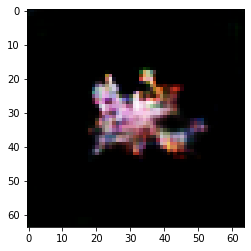

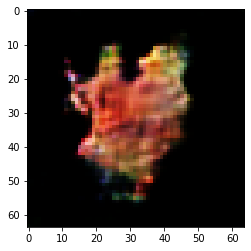

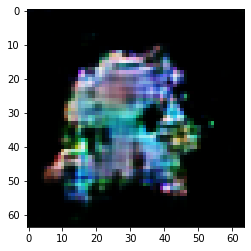

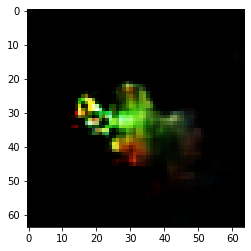

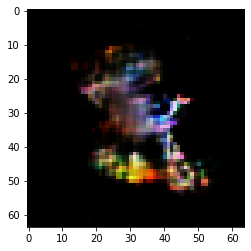

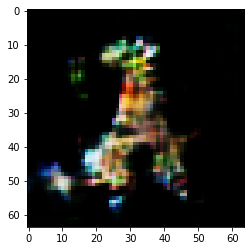

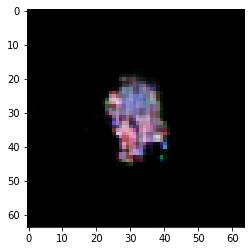

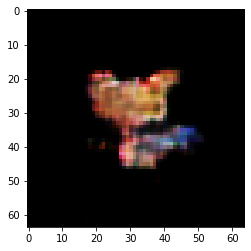

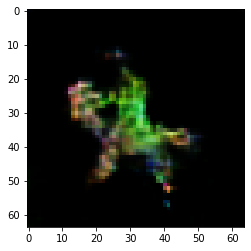

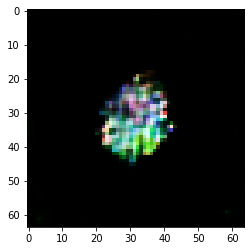

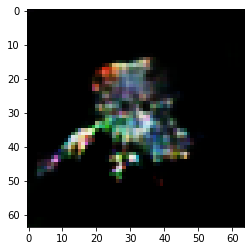

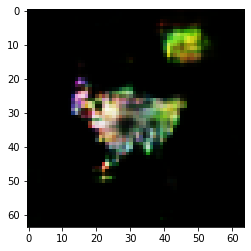

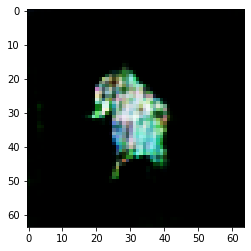

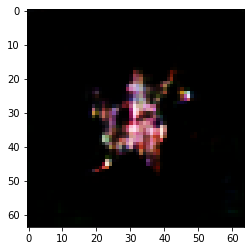

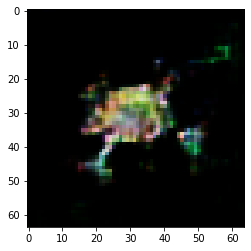

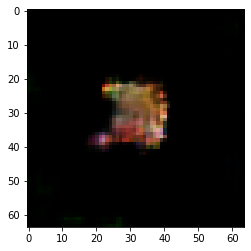

In [164]:
for i in range(100):
    noise = np.random.normal(0,1, 100)
    plt.imshow(unnormalize_tanh(generator.predict(np.array([noise]))[0]))
    plt.show()